# **Dataset Setup and Image Labelling tasks**

In [ ]:
# Importing Libraries

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

dataset_path = "/content/drive/MyDrive/dermalscan dataset"

In [ ]:
# Inspecting Folder Structure

print("Dataset Structure:\n")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/ ({len(files)} files)")
print("\n")

#  Counting Images per Class

class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

print("Image count per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count}")

Dataset Structure:

dermalscan dataset/ (0 files)
    clear skin/ (305 files)
    dark spots/ (303 files)
    wrinkles/ (300 files)
    puffy eyes/ (300 files)


Image count per class:
  clear skin: 305
  dark spots: 303
  wrinkles: 300
  puffy eyes: 300


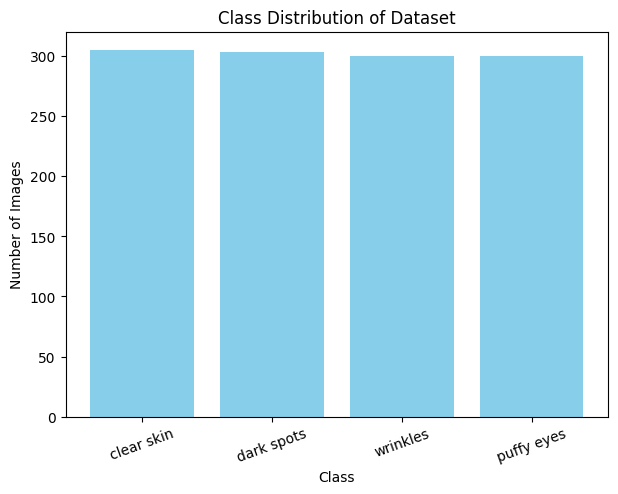

In [ ]:
# Visualization of Class Distribution

plt.figure(figsize=(7,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution of Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.show()

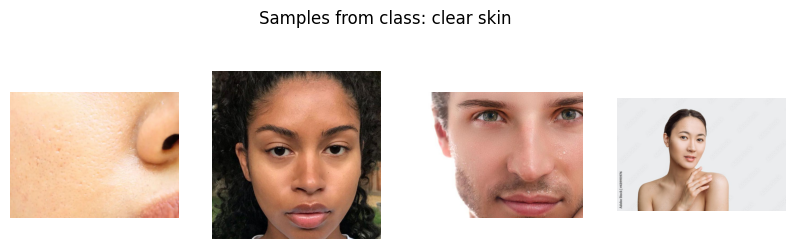

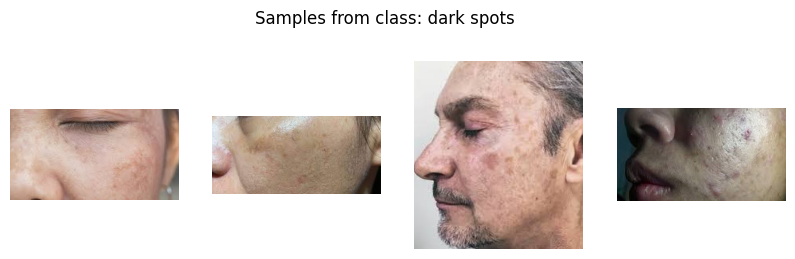

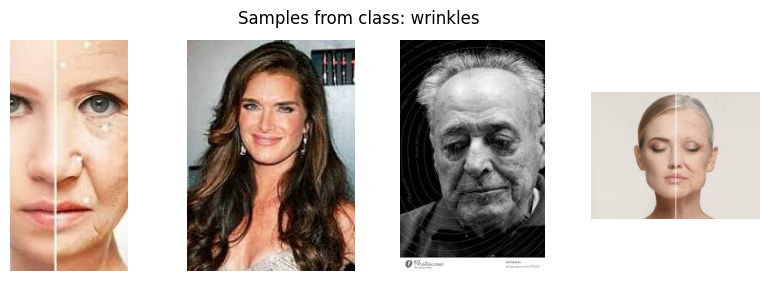

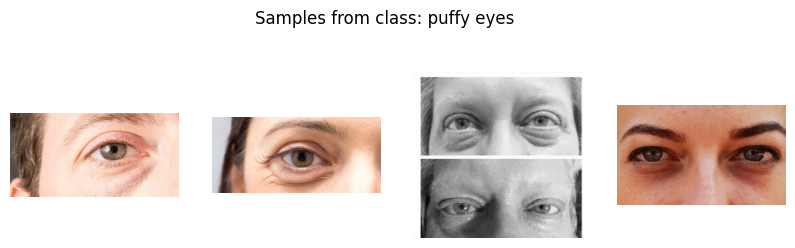

In [ ]:
# Display Few Sample Images

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        sample_imgs = os.listdir(class_dir)[31:36]  # first 4 images
        plt.figure(figsize=(10, 3))
        plt.suptitle(f"Samples from class: {class_name}")
        for idx, img_name in enumerate(sample_imgs):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = mpimg.imread(img_path)
                plt.subplot(1, 4, idx + 1)
                plt.imshow(img)
                plt.axis("off")
            except:
                pass
        plt.show()

In [ ]:
# backup
import shutil
import os

original_dataset = "/content/drive/MyDrive/dermalscan dataset"
backup_dataset = "/content/drive/MyDrive/dermalscan dataset backup"

# Created a backup (copy everything)
shutil.copytree(original_dataset, backup_dataset, dirs_exist_ok=True)
print(f"Backup created at: {backup_dataset}")

Backup created at: /content/drive/MyDrive/dermalscan dataset backup


# **Image Preprocessing and Augmentation**
 Image standardization -> Removing Duplicate Images -> Data Augmentation -> Color and Illumination Correction -> Skin Segmentation and Cropping -> Feature Enhancement -> One Hot Encoding

In [ ]:
#Image Standardization(resizing(224X224),Conversion to RGB,Normalization)

import os
import cv2
import numpy as np
from tqdm import tqdm


input_path = "/content/drive/MyDrive/dermalscan dataset"
output_path = "/content/drive/MyDrive/dermalscan dataset output/standardization"
os.makedirs(output_path, exist_ok=True)


IMG_SIZE = 224  # Standard size (EfficientNetB0 compatible)

def standardize_image(img):

    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to standard size
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalize pixel intensity (contrast adjustment)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    return img


for cls in os.listdir(input_path):
    cls_path = os.path.join(input_path, cls)
    if not os.path.isdir(cls_path):
        continue

    out_cls = os.path.join(output_path, cls)
    os.makedirs(out_cls, exist_ok=True)

    print(f"\nStandardizing images in class '{cls}' ...")

    for img_name in tqdm(os.listdir(cls_path)):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        standardized = standardize_image(img)

        # Saving standardized image
        save_path = os.path.join(out_cls, img_name)
        cv2.imwrite(save_path, cv2.cvtColor(standardized, cv2.COLOR_RGB2BGR))

print("\nImage Standardization Completed Successfully!")


Standardizing images in class 'clear skin' ...


100%|██████████| 305/305 [00:07<00:00, 42.71it/s]



Standardizing images in class 'dark spots' ...


100%|██████████| 303/303 [00:05<00:00, 53.53it/s]



Standardizing images in class 'wrinkles' ...


100%|██████████| 300/300 [00:05<00:00, 50.86it/s]



Standardizing images in class 'puffy eyes' ...


100%|██████████| 300/300 [00:06<00:00, 43.36it/s]


Image Standardization Completed Successfully!


In [ ]:
#  COUNTING DUPLICATE IMAGES
import os
import hashlib
from collections import defaultdict

dataset_path = "/content/drive/MyDrive/dermalscan dataset output/standardization"


def compute_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()


for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    hash_dict = defaultdict(list)

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        try:
            file_hash = compute_hash(img_path)
            hash_dict[file_hash].append(img_path)
        except:
            continue

    # Counting duplicates in each class
    total_duplicates = sum(len(v) - 1 for v in hash_dict.values() if len(v) > 1)
    print(f"{cls}: {total_duplicates} duplicate images")


clear skin: 0 duplicate images
dark spots: 31 duplicate images
wrinkles: 46 duplicate images
puffy eyes: 54 duplicate images


In [ ]:
# Removal of duplicate images
import os
import hashlib
from collections import defaultdict


dataset_path = "/content/drive/MyDrive/dermalscan dataset output/standardization"

def compute_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    hash_dict = defaultdict(list)

    # Computing hashes
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        try:
            file_hash = compute_hash(img_path)
            hash_dict[file_hash].append(img_path)
        except:
            continue

    # Removing duplicates (keeping one)
    for paths in hash_dict.values():
        for duplicate_img in paths[1:]:
            os.remove(duplicate_img)

# Printing count of images per class after duplicate removal
print("\n Image count per class after removing duplicates:")
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        print(f"{cls}: {count} images")



 Image count per class after removing duplicates:
clear skin: 305 images
dark spots: 272 images
wrinkles: 254 images
puffy eyes: 246 images


In [ ]:
# Data Augmentation
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from shutil import copy2


dataset_path = "/content/drive/MyDrive/dermalscan dataset output/standardization"
augmented_path = "/content/drive/MyDrive/dermalscan dataset output/augmented"
os.makedirs(augmented_path, exist_ok=True)

# Targeting number of images per class
target_count = 300

# Defining augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    output_cls_path = os.path.join(augmented_path, cls)
    os.makedirs(output_cls_path, exist_ok=True)

    # Getting all images in the class
    images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    if len(images) == 0:
        print(f" No images found in class '{cls}', skipping augmentation.")
        continue

    # Copying original images first
    for img_name in images:
        src_path = os.path.join(cls_path, img_name)
        dst_path = os.path.join(output_cls_path, img_name)
        if not os.path.exists(dst_path):
            copy2(src_path, dst_path)

    # Augmenting images until reaching target_count
    current_count = len(os.listdir(output_cls_path))
    i = 0
    while current_count < target_count:
        img_name = images[i % len(images)]
        img_path = os.path.join(cls_path, img_name)

        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generating one augmented image at a time
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_cls_path,
                                  save_prefix='aug', save_format='jpg'):
            current_count += 1
            break

        i += 1

# Final summary
print("\nData augmentation complete. Final image count per class:")
for cls in os.listdir(augmented_path):
    cls_path = os.path.join(augmented_path, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        print(f"{cls}: {count} images")





Data augmentation complete. Final image count per class:
clear skin: 305 images
dark spots: 300 images
wrinkles: 300 images
puffy eyes: 300 images


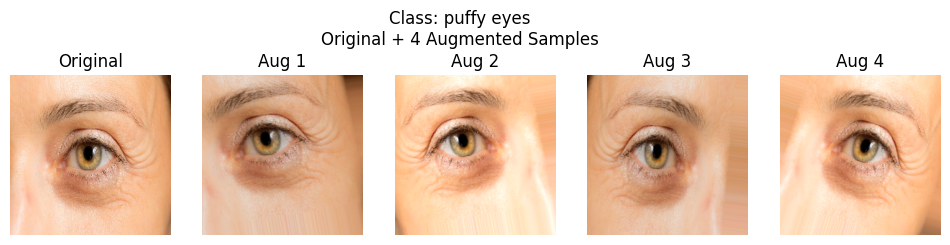

In [ ]:
#Visualization of data Augmentation

import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Picking a random class from augmented dataset
cls = random.choice(os.listdir(augmented_path))
cls_path = os.path.join(augmented_path, cls)

# Picking a random image from that class
img_name = random.choice([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
img_path = os.path.join(cls_path, img_name)

# Loading image and convert to NumPy array
img = load_img(img_path)
img_array = img_to_array(img)

# Ploting original image
plt.figure(figsize=(12, 3))
plt.subplot(1, 5, 1)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.title("Original")

# Generate and plot 4 augmented images
i = 2
for batch in datagen.flow(img_array.reshape((1,) + img_array.shape), batch_size=1):
    plt.subplot(1, 5, i)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    plt.title(f"Aug {i-1}")
    i += 1
    if i > 5:
        break

plt.suptitle(f"Class: {cls}\nOriginal + 4 Augmented Samples")
plt.show()


In [ ]:
# Color and Illumination Correction
import cv2
import numpy as np
import os


augmented_path = "/content/drive/MyDrive/dermalscan dataset output/augmented"

def apply_clahe(img):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

def gamma_correction(img, gamma=1.2):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def white_balance(img):

    result = img.copy().astype(np.float32)
    avgB = np.mean(result[:,:,0])
    avgG = np.mean(result[:,:,1])
    avgR = np.mean(result[:,:,2])
    avgGray = (avgB + avgG + avgR) / 3
    result[:,:,0] = np.clip(result[:,:,0] * (avgGray/avgB), 0, 255)
    result[:,:,1] = np.clip(result[:,:,1] * (avgGray/avgG), 0, 255)
    result[:,:,2] = np.clip(result[:,:,2] * (avgGray/avgR), 0, 255)
    return result.astype(np.uint8)

def intensity_standardization(img):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    lab_std = cv2.merge((l,a,b))
    return cv2.cvtColor(lab_std, cv2.COLOR_LAB2BGR)

# Processing all images in augmented dataset
for cls in os.listdir(augmented_path):
    cls_path = os.path.join(augmented_path, cls)
    if not os.path.isdir(cls_path):
        continue

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Step 1: CLAHE
        img = apply_clahe(img)
        # Step 2: Gamma correction
        img = gamma_correction(img, gamma=1.2)
        # Step 3: White balance
        img = white_balance(img)
        # Step 4: Intensity standardization (LAB L-channel)
        img = intensity_standardization(img)


        cv2.imwrite(img_path, img)

print("Color and Illumination correction applied to all augmented images!")


Color and Illumination correction applied to all augmented images!


In [ ]:
# Skin Segmentation and cropping
import cv2
import numpy as np
import os

input_path = "/content/drive/MyDrive/dermalscan dataset output/augmented"
output_path = "/content/drive/MyDrive/dermalscan dataset output/skin_croped"
os.makedirs(output_path, exist_ok=True)

# Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def skin_segmentation(img):
    """Segment skin regions using HSV thresholding and Otsu's method."""
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Typical skin color range in HSV
    lower = np.array([0, 40, 0], dtype=np.uint8)
    upper = np.array([25, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)

    # Otsu thresholding to refine
    _, mask_otsu = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations: dilation and closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask_clean = cv2.morphologyEx(mask_otsu, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_clean = cv2.dilate(mask_clean, kernel, iterations=1)

    return mask_clean

def crop_largest_region(img, mask):
    """Find largest connected skin region and crop."""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img  # fallback: return original

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    cropped = img[y:y+h, x:x+w]
    return cropped

# Process all images
for cls in os.listdir(input_path):
    cls_input_path = os.path.join(input_path, cls)
    cls_output_path = os.path.join(output_path, cls)
    os.makedirs(cls_output_path, exist_ok=True)

    for img_name in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Step 1: Face detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            # Use first detected face
            x, y, w, h = faces[0]
            img_face = img[y:y+h, x:x+w]
        else:
            # fallback: use full image
            img_face = img

        # Step 2: Skin segmentation
        mask = skin_segmentation(img_face)

        # Step 3: Crop largest connected skin region
        cropped_img = crop_largest_region(img_face, mask)

        # Save processed image
        save_path = os.path.join(cls_output_path, img_name)
        cv2.imwrite(save_path, cropped_img)

print(" Skin segmentation and cropping completed!")


 Skin segmentation and cropping completed!


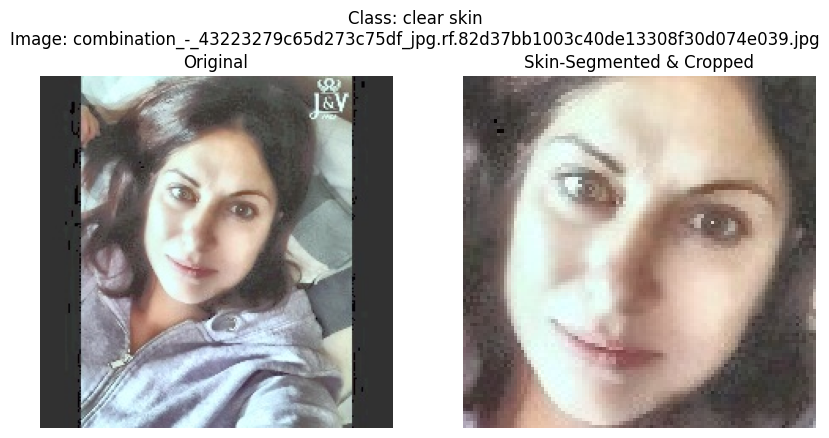

In [2]:
# Visualization of Skin Segmentation and cropping
import os
import random
import cv2
import matplotlib.pyplot as plt

# Paths
original_path = "/content/drive/MyDrive/dermalscan dataset output/augmented"
processed_path = "/content/drive/MyDrive/dermalscan dataset output/skin_croped"

# Pick a random class
cls = random.choice([c for c in os.listdir(original_path) if os.path.isdir(os.path.join(original_path, c))])
original_cls_path = os.path.join(original_path, cls)
processed_cls_path = os.path.join(processed_path, cls)

# Pick a random image
img_name = random.choice([f for f in os.listdir(original_cls_path) if os.path.isfile(os.path.join(original_cls_path, f))])
original_img_path = os.path.join(original_cls_path, img_name)
processed_img_path = os.path.join(processed_cls_path, img_name)

# Load images
original_img = cv2.imread(original_img_path)
processed_img = cv2.imread(processed_img_path)

# Convert BGR → RGB
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

# Plot side by side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(original_img)
plt.axis('off')
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(processed_img)
plt.axis('off')
plt.title("Skin-Segmented & Cropped")

plt.suptitle(f"Class: {cls}\nImage: {img_name}")
plt.show()



In [3]:
# Feature Enhancement
import cv2
import os
import numpy as np
from tqdm import tqdm

# Input and output directories
input_dir = "/content/drive/MyDrive/dermalscan dataset output/skin_croped"
output_dir = "/content/drive/MyDrive/dermalscan dataset output/feature_enhanced"
os.makedirs(output_dir, exist_ok=True)

# Enhancement parameters
gamma_value = 1.2  # adjust between 0.8–1.5 depending on brightness
clip_limit = 2.0   # CLAHE contrast limit
tile_grid_size = (8, 8)

# Apply enhancement functions
def apply_feature_enhancement(img):
    # --- Convert to LAB for CLAHE ---
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_rgb = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

    # --- Gamma correction ---
    gamma_corrected = np.power(enhanced_rgb / 255.0, gamma_value)
    gamma_corrected = np.uint8(np.clip(gamma_corrected * 255, 0, 255))

    # --- Contrast stretching ---
    in_min = np.percentile(gamma_corrected, 2)
    in_max = np.percentile(gamma_corrected, 98)
    stretched = np.clip((gamma_corrected - in_min) * 255.0 / (in_max - in_min), 0, 255).astype(np.uint8)

    return stretched

# Processing dataset
for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    out_cls_path = os.path.join(output_dir, cls)
    os.makedirs(out_cls_path, exist_ok=True)

    print(f"\n Enhancing features for class: {cls}")
    for img_name in tqdm(os.listdir(cls_path)):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        enhanced = apply_feature_enhancement(img_rgb)

        # Saving enhanced image
        out_path = os.path.join(out_cls_path, img_name)
        cv2.imwrite(out_path, cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR))

print("\n Feature enhancement completed and saved to:", output_dir)



 Enhancing features for class: clear skin


100%|██████████| 305/305 [00:12<00:00, 25.11it/s]



 Enhancing features for class: dark spots


100%|██████████| 300/300 [00:11<00:00, 27.27it/s]



 Enhancing features for class: wrinkles


100%|██████████| 300/300 [00:14<00:00, 21.25it/s]



 Enhancing features for class: puffy eyes


100%|██████████| 300/300 [00:13<00:00, 22.86it/s]


 Feature enhancement completed and saved to: /content/drive/MyDrive/dermalscan dataset output/feature_enhanced


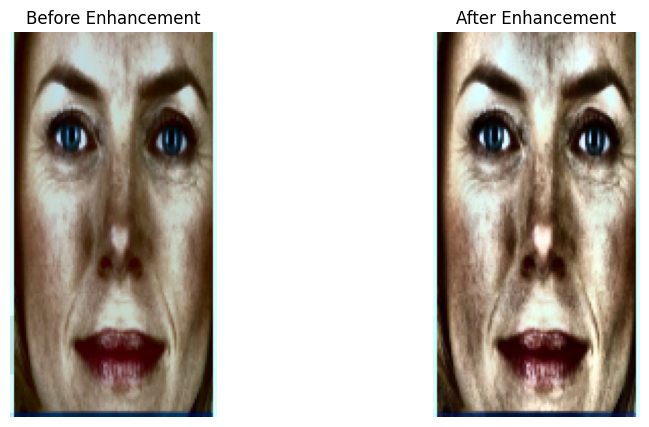

In [18]:
# Visualization of feature Enhancement
import random
import matplotlib.pyplot as plt

# Picking random class and image
cls = random.choice(os.listdir(input_dir))
img_name = random.choice(os.listdir(os.path.join(input_dir, cls)))

orig_path = os.path.join(input_dir, cls, img_name)
enh_path = os.path.join(output_dir, cls, img_name)

orig = cv2.cvtColor(cv2.imread(orig_path), cv2.COLOR_BGR2RGB)
enh = cv2.cvtColor(cv2.imread(enh_path), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.title("Before Enhancement")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(enh)
plt.title("After Enhancement")
plt.axis('off')

plt.show()


In [13]:
# one Hot Encoding
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to my final preprocessed dataset (feature enhanced)
dataset_path = "/content/drive/MyDrive/dermalscan dataset output/feature_enhanced"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


datagen = ImageDataGenerator()

dataset = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


images, labels = next(dataset)

print(" One-hot encoded dataset ready!")
print("Images tensor shape:", images.shape)
print("Labels tensor shape:", labels.shape)
print("Example one-hot vector:", labels[0])
print("Class mapping:", dataset.class_indices)



Found 1205 images belonging to 4 classes.
 One-hot encoded dataset ready!
Images tensor shape: (32, 224, 224, 3)
Labels tensor shape: (32, 4)
Example one-hot vector: [0. 0. 1. 0.]
Class mapping: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}
